In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from medmnist import OCTMNIST
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Define the dataset
dataset = OCTMNIST(root='./medmnist/', split='train', download=True, transform=transform)

# Calculate sizes for each split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Using downloaded and verified file: ./medmnist/octmnist.npz


In [3]:
# Dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# Dataset Info
dataset.info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'url_224': 'https://zenodo.org/records/10519652/files/octmnist_224.npz?downl

In [5]:
# Check image channel if 1, grayscale image if 3, RGB image
for image, label in trainloader:
    if image.shape[1] == 1:
        print("Grayscale image")
    else:
        print("RGB image")
    break

Grayscale image


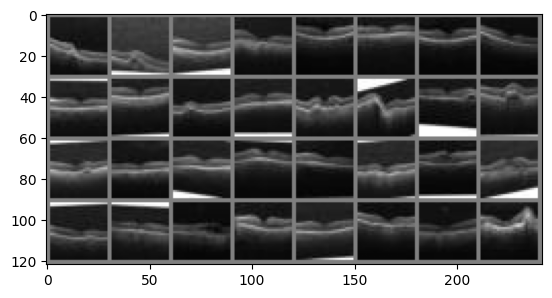

choroidal neovascularization choroidal neovascularization normal choroidal neovascularization normal normal normal normal normal normal choroidal neovascularization normal choroidal neovascularization choroidal neovascularization choroidal neovascularization drusen choroidal neovascularization normal normal normal drusen choroidal neovascularization diabetic macular edema choroidal neovascularization drusen drusen choroidal neovascularization diabetic macular edema normal choroidal neovascularization drusen choroidal neovascularization


In [6]:
classes = list(dataset.info['label'].values())

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with p=0.2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Applying dropout after the first fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Applying dropout after the second fully connected layer
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [8]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
# Torchinfo Summary
torchinfoSummary = torchinfo.summary(modelCNN, input_data=torch.randn(
    batch_size, 1, 28, 28))  # batch_size=32, channels=1, height=28, width=28
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [32, 16, 12, 12]          --
├─Conv2d: 1-3                            [32, 32, 8, 8]            12,832
├─MaxPool2d: 1-4                         [32, 32, 4, 4]            --
├─Linear: 1-5                            [32, 512]                 262,656
├─Dropout: 1-6                           [32, 512]                 --
├─Linear: 1-7                            [32, 256]                 131,328
├─Dropout: 1-8                           [32, 256]                 --
├─Linear: 1-9                            [32, 4]                   1,028
Total params: 408,260
Trainable params: 408,260
Non-trainable params: 0
Total mult-adds (M): 46.59
Input size (MB): 0.10
Forward/backward pass size (MB): 3.08
Params size (MB): 1.63
Estimated Total Size (MB)

In [10]:
# Define regularization (L2)
l2_reg = 0.001 # Regularization parameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001, weight_decay=l2_reg)


In [11]:
import time

startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 10
max_consecutive = 0
consecutive_count = 0
previous_number = float('inf')

for epoch in range(epochs):
    training_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN(inputs)
        labels = labels.flatten()
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()

        if i % 500 == 499:
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()

            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            training_loss = round((training_loss / 500), 3)
            validation_loss = round((validation_loss / len(valloader)), 3)
            testing_loss = round((testing_loss / len(testloader)), 3)

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

            training_loss_plt_arr.append(training_loss)
            validation_loss_plt_arr.append(validation_loss)
            testing_loss_plt_arr.append(testing_loss)
            training_loss = 0.0

            # Early stopping condition
            if validation_loss < previous_number:
                previous_number = validation_loss
                consecutive_count = 0
            else:
                consecutive_count += 1
                max_consecutive = max(max_consecutive, consecutive_count)
                if max_consecutive == 4:
                    print("\nStopping training as Validation Loss stopped improving.")
                    break

    if max_consecutive == 4:
        break

print("Finished Training")

endTime = time.time()
time_to_train = (endTime - startTime)

# Convert total time to minutes and seconds
minutes = int(time_to_train // 60)
seconds = int(time_to_train % 60)

print(f"\nTime to train: {minutes}min {seconds}sec")

[1, 500], Training loss: 0.896, Validation loss: 0.697, Testing loss: 0.696
[1, 1000], Training loss: 0.638, Validation loss: 0.582, Testing loss: 0.582
[1, 1500], Training loss: 0.562, Validation loss: 0.554, Testing loss: 0.557
[1, 2000], Training loss: 0.53, Validation loss: 0.515, Testing loss: 0.516
[2, 500], Training loss: 0.508, Validation loss: 0.508, Testing loss: 0.511
[2, 1000], Training loss: 0.502, Validation loss: 0.563, Testing loss: 0.564
[2, 1500], Training loss: 0.479, Validation loss: 0.476, Testing loss: 0.482
[2, 2000], Training loss: 0.468, Validation loss: 0.465, Testing loss: 0.472
[3, 500], Training loss: 0.449, Validation loss: 0.45, Testing loss: 0.452
[3, 1000], Training loss: 0.451, Validation loss: 0.44, Testing loss: 0.447
[3, 1500], Training loss: 0.435, Validation loss: 0.44, Testing loss: 0.445
[3, 2000], Training loss: 0.446, Validation loss: 0.427, Testing loss: 0.432
[4, 500], Training loss: 0.417, Validation loss: 0.434, Testing loss: 0.443
[4, 100

In [12]:
# Save model with weights
torch.save(modelCNN.state_dict(), 'ngupta22_assignment0_part_3.pt')

In [13]:
# Losses visualisation
def LossesPlot():
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [14]:
# Updated Performance Evaluation
def loadersAccuracy(loader):
    modelCNN.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC


def perfEvaluation():
    modelCNN.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        testloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(valloader)
    train_accuracy, _, _, _, _ = loadersAccuracy(trainloader)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=4)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

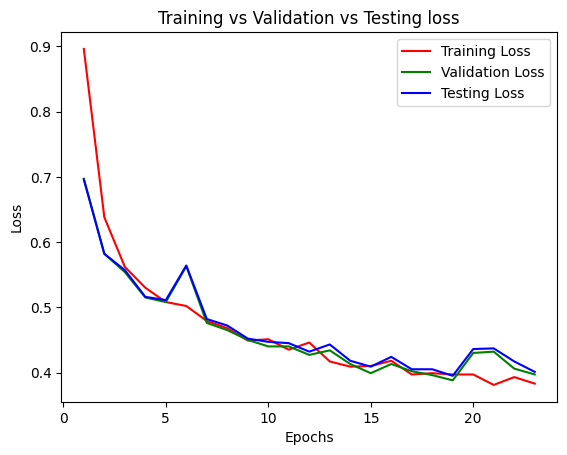

Accuracy on the testing dataset = 86.18
Precision = 0.85
Recall = 0.86
Fscore = 0.84


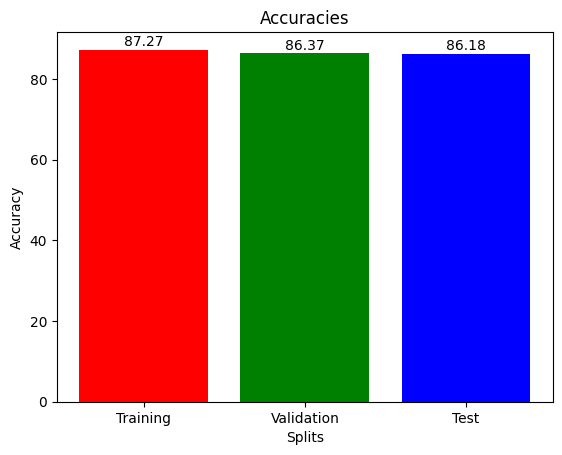

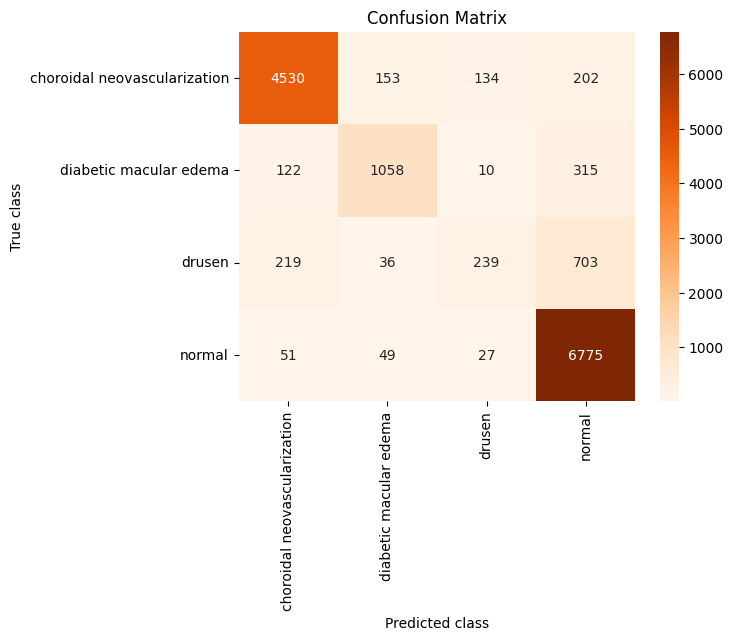

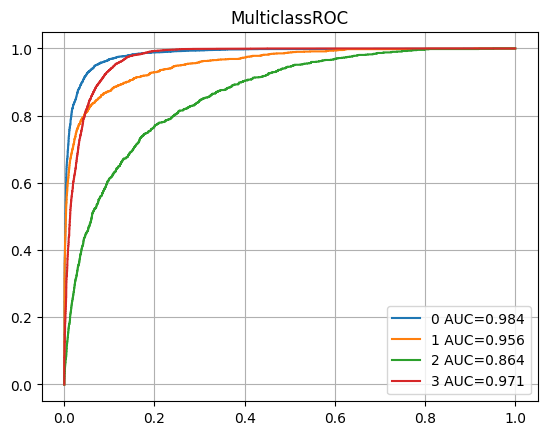

In [15]:
LossesPlot()
perfEvaluation()

# References

1. https://pandas.pydata.org/docs/
1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://github.com/MedMNIST/MedMNIST/
1. https://lightning.ai/docs/torchmetrics/stable/
1. https://numpy.org/doc/stable/
1. Part 3, Steps 3 and 5 is based on CSE 574 Machine Learning Assignment 2 Part 3 submission by Nikhil Gupta